In [3]:
#Used to make data more uniform across screen.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
#Import packages used here:
# for initial data exploration:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math

#For modeling and model viewing. 
import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical #Image generator used for transformation to categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
#from sklearn.model_selection import train_test_split  #could have used on the consolidated file.
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
#from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input

In [5]:
#This will setup my directories for all of the data files in the 100-bird-species dataset. 
BASE_DIR = 'dataset'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

BASE_DIR contains  ['test', 'train', 'valid']


In [6]:
#This will establish the prediction groups for the model.
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)

Category_count = len(CATEGORIES)

250 CATEGORIES are  ['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BROWN NOODY', 'BROWN THRASHER', 'CACTUS WREN', 'CALIFORNIA CONDOR', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CANARY', 'CAPE MAY WARBLER', 'CAPUCHINBIRD', 'CARMINE BEE-EATER', 'CASPIAN TERN', 'CASSOWARY', 'CH

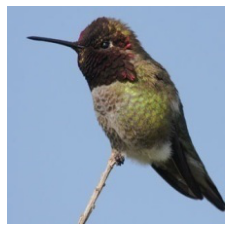

Figures are  (224, 224, 3)


In [8]:
#Load an image and determine image shape for analysis.
IMAGE = load_img("dataset/train/ANNAS HUMMINGBIRD/025.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [9]:
#This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255, )

In [10]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data)) #Will be used to determine steps_per_epoch in my models.
Train_groups = len(train_data)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))

Found 35215 images belonging to 250 classes.
data groups: 1101
Found 1250 images belonging to 250 classes.
data groups: 40
validation image qty: 1250
Found 1250 images belonging to 250 classes.
data groups: 40


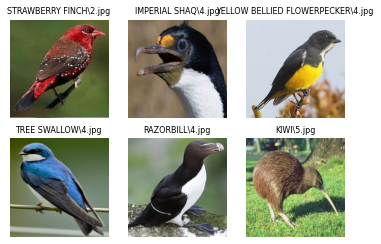

In [11]:
#create seperate labels for images 
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,+1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

In [ ]:
#Let's try the mobilenet with ReduceLROnPlateau - 93% accuracy
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(Category_count)) 
model.add(Activation('softmax'))

model.summary()

#Compile
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.001, 
                                                  momentum=0.9, nesterov=True),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
#fit model
history = model.fit_generator( 
    train_data, 
    steps_per_epoch = Train_groups, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)]) 
                # left verbose 1 so I could see the learning rate decay

17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
activation (Activation)      (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 250)               12544250  
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
Total params: 15,773,114
Trainable params: 12,544,250
Non-trainable params: 3,228,864
_________________________________________________________________
Epoch 1/50


C:\Users\osodr\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1101/1101 [==============================] - ETA: 0s - loss: 4.2885 - accuracy: 0.5270

In [ ]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])